<a href="https://colab.research.google.com/github/RajeswariKumaran/SSLMethodsAnalysis/blob/main/UDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#revamped code

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# ---------- Cutout Augmentation ----------
class Cutout:
    def __init__(self, mask_size, p=1.0, mask_color=0):
        self.mask_size = mask_size
        self.p = p
        self.mask_color = mask_color

    def __call__(self, img):
        if random.random() > self.p:
            return img
        w, h = img.size
        mask_size_half = self.mask_size // 2
        cx = random.randint(mask_size_half, w - mask_size_half)
        cy = random.randint(mask_size_half, h - mask_size_half)
        x1 = cx - mask_size_half
        y1 = cy - mask_size_half
        x2 = cx + mask_size_half
        y2 = cy + mask_size_half
        img = img.copy()
        img.paste(self.mask_color, (x1, y1, x2, y2))
        return img

# ---------- Simple CNN Model ----------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(8*8*128, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ---------- Strong Augmentation Pipeline ----------
class StrongTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.RandAugment(num_ops=2, magnitude=9),
            Cutout(mask_size=16, p=1.0),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.247, 0.243, 0.261))
        ])

    def __call__(self, img):
        return self.transform(img)

# ---------- UDA Training Function ----------
def train_uda(model, labelled_loader, unlabelled_loader, test_loader, device,
              epochs=30, lambda_u=1.0, threshold=0.85):

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    strong_aug = StrongTransform()

    for epoch in range(epochs):
        model.train()
        total_lab_loss = 0
        total_unsup_loss = 0
        correct = 0
        total = 0

        unlab_iter = iter(unlabelled_loader)

        for batch_idx, (lab_x, lab_y) in enumerate(labelled_loader):
            try:
                unlab_x, _ = next(unlab_iter)
            except StopIteration:
                unlab_iter = iter(unlabelled_loader)
                unlab_x, _ = next(unlab_iter)

            lab_x, lab_y = lab_x.to(device), lab_y.to(device)
            unlab_x = unlab_x.to(device)

            # Apply strong augmentation on unlabelled data
            unlab_x_aug = torch.stack([strong_aug(img.cpu()) for img in unlab_x]).to(device)

            # Supervised loss
            logits_lab = model(lab_x)
            loss_lab = criterion(logits_lab, lab_y)

            # Unsupervised loss with pseudo-label masking
            with torch.no_grad():
                logits_weak = model(unlab_x)
                probs_weak = F.softmax(logits_weak, dim=1)
                max_probs, pseudo_labels = torch.max(probs_weak, dim=1)
                mask = max_probs.ge(threshold).float()

            logits_strong = model(unlab_x_aug)
            log_probs_strong = F.log_softmax(logits_strong, dim=1)
            loss_unsup = F.kl_div(log_probs_strong, probs_weak, reduction='none').sum(dim=1)
            loss_unsup = (loss_unsup * mask).mean()

            loss = loss_lab + lambda_u * loss_unsup

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_lab_loss += loss_lab.item()
            total_unsup_loss += loss_unsup.item()

            _, preds = torch.max(logits_lab, 1)
            correct += (preds == lab_y).sum().item()
            total += lab_y.size(0)

        acc = correct / total
        print(f"[Epoch {epoch+1}] Sup Loss: {total_lab_loss:.4f} | Unsup Loss: {total_unsup_loss:.4f} | Sup Acc: {acc:.4f}")

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x_test, y_test in test_loader:
                x_test, y_test = x_test.to(device), y_test.to(device)
                logits = model(x_test)
                _, preds = torch.max(logits, 1)
                correct += (preds == y_test).sum().item()
                total += y_test.size(0)
        print(f"→ Test Acc: {correct / total:.4f}")

    return model

# ---------- Main ----------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    normalize = transforms.Normalize((0.4914, 0.4822, 0.4465),
                                     (0.247, 0.243, 0.261))

    weak_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        normalize
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    full_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=weak_transform)
    test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    num_labelled = 4000
    indices = np.arange(len(full_train))
    np.random.seed(42)
    np.random.shuffle(indices)
    labelled_idx = indices[:num_labelled]
    unlabelled_idx = indices[num_labelled:]

    labelled_set = Subset(full_train, labelled_idx)
    unlabelled_set = Subset(full_train, unlabelled_idx)

    labelled_loader = DataLoader(labelled_set, batch_size=64, shuffle=True, num_workers=2, drop_last=True)
    unlabelled_loader = DataLoader(unlabelled_set, batch_size=64, shuffle=True, num_workers=2, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)

    model = SimpleCNN(num_classes=10)
    trained_model = train_uda(model, labelled_loader, unlabelled_loader, test_loader, device,
                              epochs=30, lambda_u=1.0, threshold=0.85)

    torch.save(trained_model.state_dict(), 'uda_cifar10_simplecnn.pth')


100%|██████████| 170M/170M [00:03<00:00, 48.1MB/s]


[Epoch 1] Sup Loss: 123.3781 | Unsup Loss: 0.0838 | Sup Acc: 0.2676
→ Test Acc: 0.3909
[Epoch 2] Sup Loss: 104.6423 | Unsup Loss: 0.8853 | Sup Acc: 0.3722
→ Test Acc: 0.4190
[Epoch 3] Sup Loss: 96.5876 | Unsup Loss: 1.8482 | Sup Acc: 0.4289
→ Test Acc: 0.4493
[Epoch 4] Sup Loss: 93.8238 | Unsup Loss: 2.1092 | Sup Acc: 0.4488
→ Test Acc: 0.4876
[Epoch 5] Sup Loss: 88.9875 | Unsup Loss: 3.5253 | Sup Acc: 0.4730
→ Test Acc: 0.5128
[Epoch 6] Sup Loss: 85.1398 | Unsup Loss: 4.1963 | Sup Acc: 0.4897
→ Test Acc: 0.5246
[Epoch 7] Sup Loss: 83.1982 | Unsup Loss: 4.9054 | Sup Acc: 0.5023
→ Test Acc: 0.5342
[Epoch 8] Sup Loss: 79.4553 | Unsup Loss: 6.5560 | Sup Acc: 0.5325
→ Test Acc: 0.5413
[Epoch 9] Sup Loss: 76.6451 | Unsup Loss: 7.8317 | Sup Acc: 0.5383
→ Test Acc: 0.5431
[Epoch 10] Sup Loss: 73.9037 | Unsup Loss: 9.0276 | Sup Acc: 0.5638
→ Test Acc: 0.5496
[Epoch 11] Sup Loss: 70.8040 | Unsup Loss: 9.8043 | Sup Acc: 0.5814
→ Test Acc: 0.5787
[Epoch 12] Sup Loss: 68.1773 | Unsup Loss: 12.6255

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

def evaluate(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    # Flatten predictions and labels
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()

    # Compute accuracy
    accuracy = np.mean(y_pred == y_true)
    print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ],
                yticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


✅ Test Accuracy: 63.47%

📊 Classification Report:
              precision    recall  f1-score   support

    airplane       0.75      0.64      0.69      1000
  automobile       0.79      0.71      0.74      1000
        bird       0.54      0.51      0.52      1000
         cat       0.38      0.65      0.48      1000
        deer       0.59      0.56      0.58      1000
         dog       0.55      0.46      0.50      1000
        frog       0.81      0.63      0.71      1000
       horse       0.75      0.66      0.70      1000
        ship       0.81      0.72      0.76      1000
       truck       0.65      0.81      0.72      1000

    accuracy                           0.63     10000
   macro avg       0.66      0.63      0.64     10000
weighted avg       0.66      0.63      0.64     10000



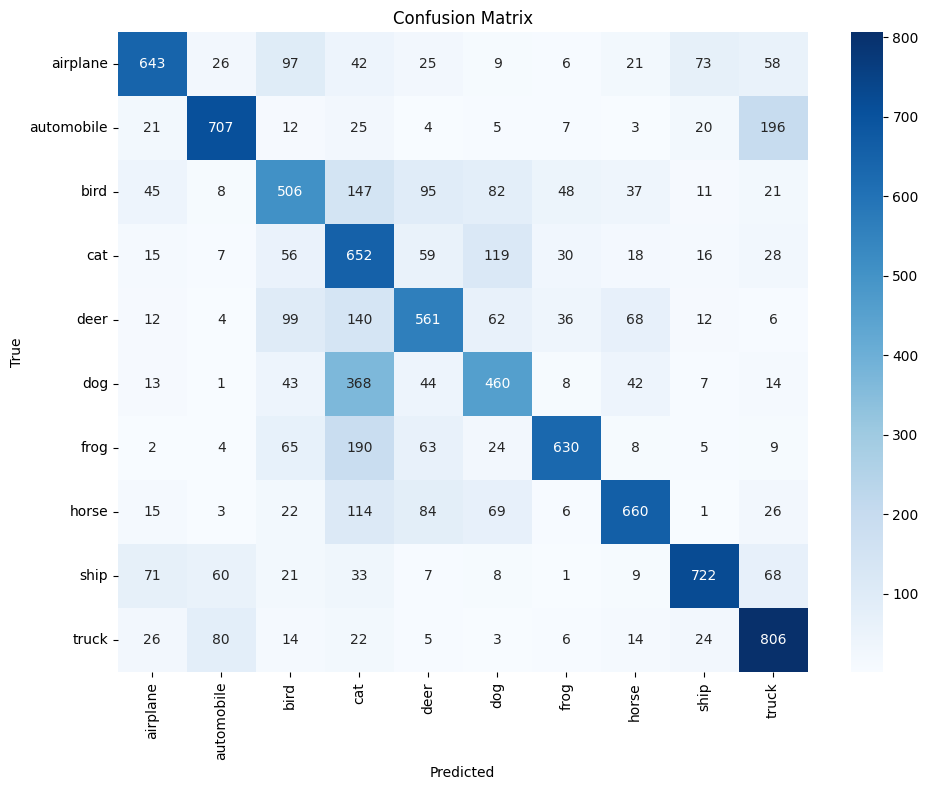

In [ ]:
model = SimpleCNN(num_classes=10)
model.load_state_dict(torch.load('uda_cifar10_simplecnn.pth'))
model.to(device)
evaluate(model, test_loader, device)

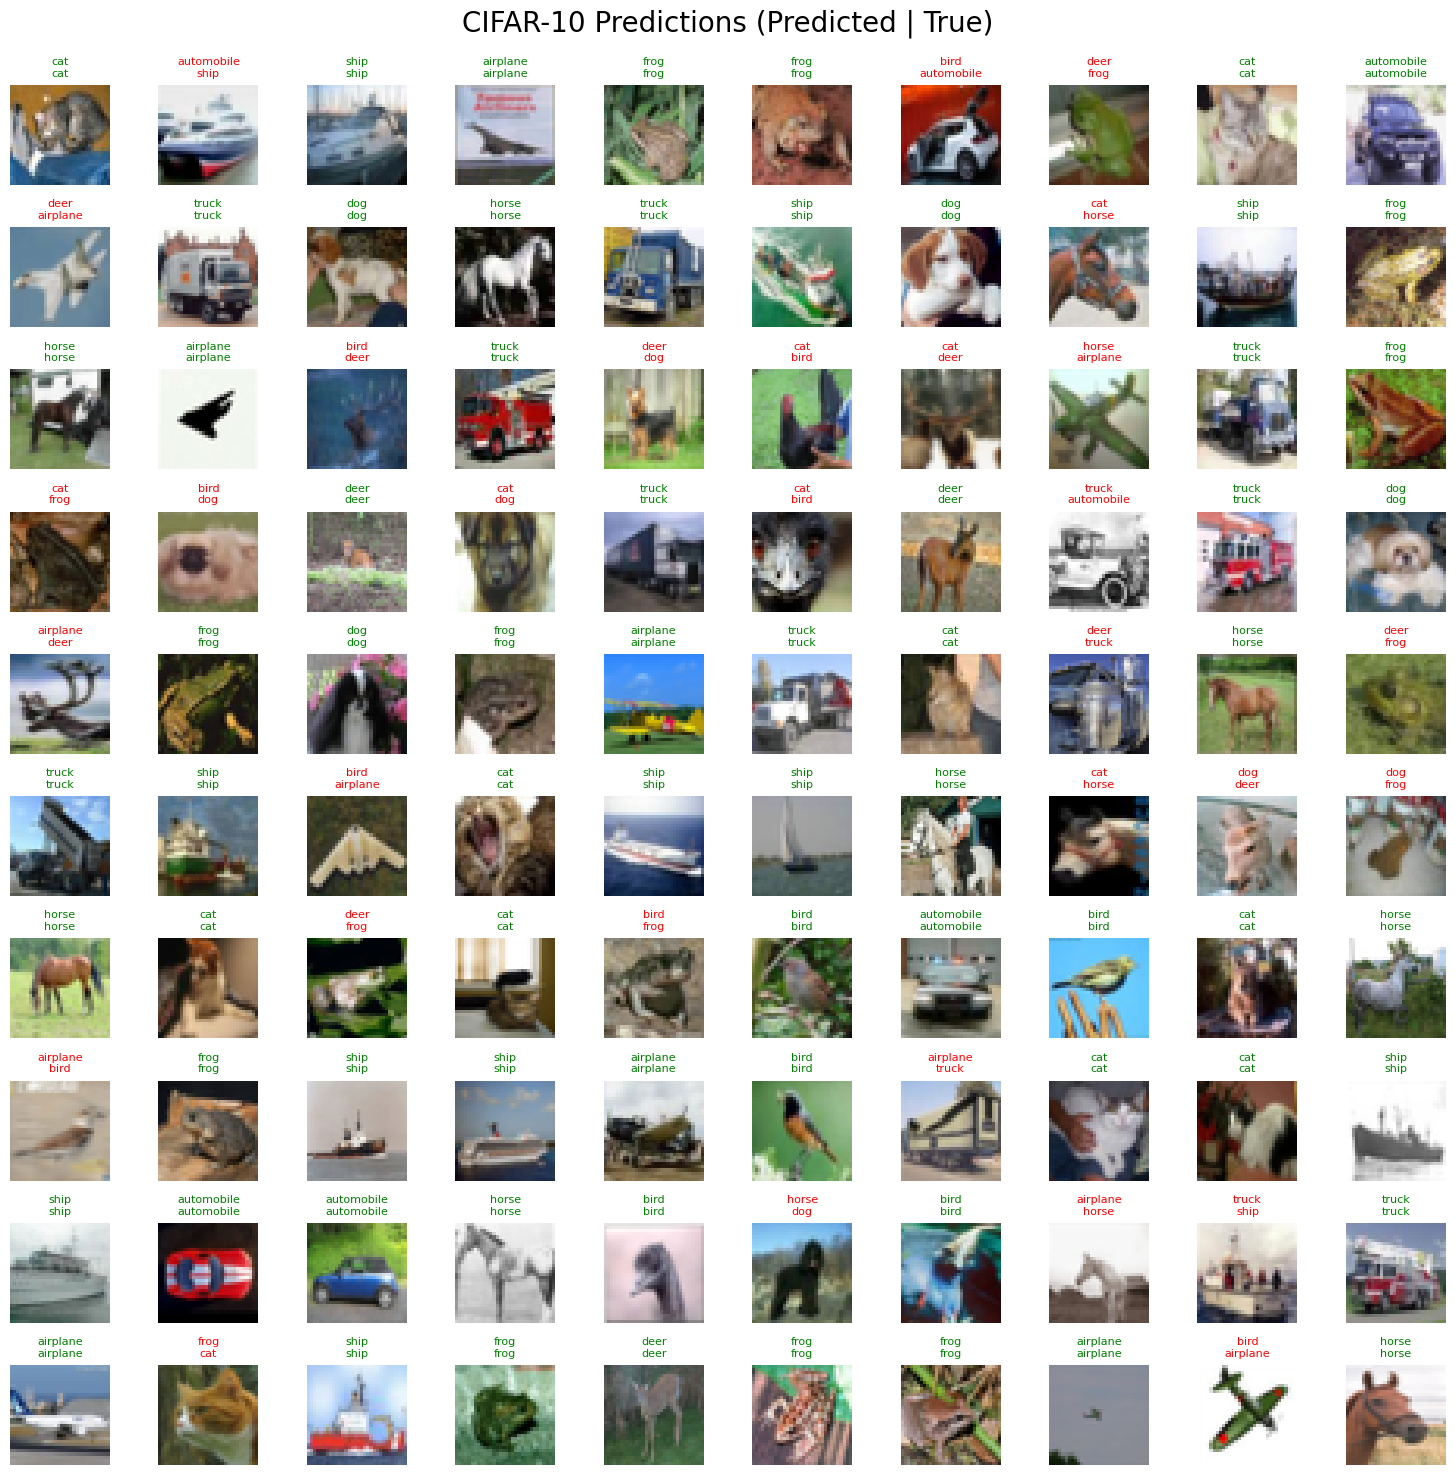

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def imshow(img_tensor):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
    std = torch.tensor([0.247, 0.243, 0.261]).view(3,1,1)
    img = img_tensor * std + mean  # unnormalize
    npimg = img.permute(1,2,0).cpu().numpy()
    npimg = np.clip(npimg, 0, 1)
    return npimg

model.eval()
images_to_show = 100
batch_size = 100  # We'll grab 1 batch of 100 images from test_loader

# Get one batch
data_iter = iter(test_loader)
images, labels = next(data_iter)  # images.shape = [batch_size, 3, 32, 32]

# Run model predictions
with torch.no_grad():
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)
    preds = preds.cpu()

# Plot 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(15,15))
fig.suptitle('CIFAR-10 Predictions (Predicted | True)', fontsize=20)

for i in range(images_to_show):
    ax = axes[i//10, i%10]
    img_np = imshow(images[i])
    ax.imshow(img_np)
    ax.axis('off')
    pred_label = classes[preds[i]]
    true_label = classes[labels[i]]
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'{pred_label}\n{true_label}', color=color, fontsize=8)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

In [ ]:
# with wideresnet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import RandAugment
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import math
from tqdm import tqdm

# ---------------- WideResNet ----------------
# From: https://github.com/meliketoy/wide-resnet.pytorch/blob/master/networks/wide_resnet.py
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, drop_rate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.droprate = drop_rate
        self.equalInOut = in_planes == out_planes
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, 1, stride=stride, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, drop_rate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, drop_rate)

    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, drop_rate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes,
                                i == 0 and stride or 1, drop_rate))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth=28, widen_factor=2, num_classes=10, drop_rate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert ((depth - 4) % 6 == 0), 'Depth should be 6n+4'
        n = (depth - 4) // 6
        block = BasicBlock
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, drop_rate)
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, drop_rate)
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, drop_rate)
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

# ---------------- Augmentations ----------------
class Cutout:
    def __init__(self, mask_size, p=1.0, mask_color=0):
        self.mask_size = mask_size
        self.p = p
        self.mask_color = mask_color

    def __call__(self, img):
        if random.random() > self.p:
            return img
        w, h = img.size
        mask_size_half = self.mask_size // 2
        cx = random.randint(mask_size_half, w - mask_size_half)
        cy = random.randint(mask_size_half, h - mask_size_half)
        x1 = cx - mask_size_half
        y1 = cy - mask_size_half
        x2 = cx + mask_size_half
        y2 = cy + mask_size_half
        img = img.copy()
        img.paste(self.mask_color, (x1, y1, x2, y2))
        return img

class StrongTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            RandAugment(num_ops=2, magnitude=9),
            Cutout(mask_size=16, p=1.0),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.247, 0.243, 0.261))
        ])

    def __call__(self, img):
        return self.transform(img)

# ---------------- Ramp-up Scheduler ----------------
def sigmoid_rampup(current, rampup_length):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current, 0.0, rampup_length)
        phase = 1.0 - current / rampup_length
        return float(np.exp(-5.0 * phase * phase))

# ---------------- UDA Training ----------------
def train_uda(model, labelled_loader, unlabelled_loader, test_loader, device,
              epochs=50, lambda_u_max=1.0, threshold=0.95, rampup_length=10):

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.003)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss()
    consistency_criterion = nn.KLDivLoss(reduction='batchmean')
    strong_aug = StrongTransform()

    for epoch in range(epochs):
        model.train()
        lambda_u = lambda_u_max * sigmoid_rampup(epoch, rampup_length)

        total_lab_loss, total_unsup_loss, correct, total = 0, 0, 0, 0
        unlab_iter = iter(unlabelled_loader)

        for (lab_x, lab_y) in tqdm(labelled_loader, desc=f"Epoch {epoch+1}", leave=False):
            try:
                unlab_x, _ = next(unlab_iter)
            except StopIteration:
                unlab_iter = iter(unlabelled_loader)
                unlab_x, _ = next(unlab_iter)

            lab_x, lab_y = lab_x.to(device), lab_y.to(device)
            unlab_x = unlab_x.to(device)
            unlab_x_aug = torch.stack([strong_aug(img.cpu()) for img in unlab_x]).to(device)

            # Supervised loss
            logits_lab = model(lab_x)
            loss_lab = criterion(logits_lab, lab_y)

            # Unsupervised loss
            with torch.no_grad():
                logits_weak = model(unlab_x)
                probs_weak = F.softmax(logits_weak, dim=1)
                max_probs, pseudo_labels = torch.max(probs_weak, dim=1)
                mask = max_probs.ge(threshold).float()

            logits_strong = model(unlab_x_aug)
            log_probs_strong = F.log_softmax(logits_strong, dim=1)
            loss_unsup = F.kl_div(log_probs_strong, probs_weak, reduction='none').sum(dim=1)
            loss_unsup = (loss_unsup * mask).mean()

            loss = loss_lab + lambda_u * loss_unsup

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_lab_loss += loss_lab.item()
            total_unsup_loss += loss_unsup.item()
            _, preds = torch.max(logits_lab, 1)
            correct += (preds == lab_y).sum().item()
            total += lab_y.size(0)

        scheduler.step()
        acc = correct / total
        print(f"[Epoch {epoch+1}] Sup Loss: {total_lab_loss:.4f} | Unsup Loss: {total_unsup_loss:.4f} | Sup Acc: {acc:.4f} | λ_u: {lambda_u:.2f}")


        # --- Evaluation ---
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x_test, y_test in test_loader:
                x_test, y_test = x_test.to(device), y_test.to(device)
                logits = model(x_test)
                _, preds = torch.max(logits, 1)
                correct += (preds == y_test).sum().item()
                total += y_test.size(0)
        test_acc = correct / total
        print(f"→ Test Acc: {test_acc:.4f}")

        # Optional: Save best model
        if epoch == 0 or test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'uda_best_model.pth')
            print("✅ Saved new best model")

    return model



In [ ]:
# ---------- Main ----------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    normalize = transforms.Normalize((0.4914, 0.4822, 0.4465),
                                     (0.247, 0.243, 0.261))

    weak_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        normalize
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    full_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=weak_transform)
    test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    num_labelled = 4000
    indices = np.arange(len(full_train))
    np.random.seed(42)
    np.random.shuffle(indices)
    labelled_idx = indices[:num_labelled]
    unlabelled_idx = indices[num_labelled:]

    labelled_set = Subset(full_train, labelled_idx)
    unlabelled_set = Subset(full_train, unlabelled_idx)

    labelled_loader = DataLoader(labelled_set, batch_size=64, shuffle=True, num_workers=2, drop_last=True)
    unlabelled_loader = DataLoader(unlabelled_set, batch_size=64, shuffle=True, num_workers=2, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)

    model = WideResNet(num_classes=10)
    trained_model = train_uda(model, labelled_loader, unlabelled_loader, test_loader, device,
                              epochs=30, lambda_u_max=1.0, threshold=0.95, rampup_length=10)

    # model, labelled_loader, unlabelled_loader, test_loader, device,
    #           epochs=50, lambda_u_max=1.0, threshold=0.95, rampup_length=10):

    torch.save(trained_model.state_dict(), 'uda_cifar10_wideresnet.pth')
#

[Epoch 1] Sup Loss: 126.0761 | Unsup Loss: 0.0888 | Sup Acc: 0.2162 | λ_u: 0.01


→ Test Acc: 0.1984
✅ Saved new best model


[Epoch 2] Sup Loss: 115.4293 | Unsup Loss: 0.0000 | Sup Acc: 0.2699 | λ_u: 0.02


→ Test Acc: 0.2669
✅ Saved new best model


[Epoch 3] Sup Loss: 111.9875 | Unsup Loss: 0.0000 | Sup Acc: 0.3029 | λ_u: 0.04


→ Test Acc: 0.3130
✅ Saved new best model


[Epoch 4] Sup Loss: 107.2946 | Unsup Loss: 0.0000 | Sup Acc: 0.3294 | λ_u: 0.09


→ Test Acc: 0.3404
✅ Saved new best model


[Epoch 5] Sup Loss: 105.2603 | Unsup Loss: 0.0000 | Sup Acc: 0.3531 | λ_u: 0.17


→ Test Acc: 0.2858


[Epoch 6] Sup Loss: 101.2966 | Unsup Loss: 0.0000 | Sup Acc: 0.3715 | λ_u: 0.29


→ Test Acc: 0.3322


[Epoch 7] Sup Loss: 98.7521 | Unsup Loss: 0.0000 | Sup Acc: 0.4027 | λ_u: 0.45


→ Test Acc: 0.4050
✅ Saved new best model


[Epoch 8] Sup Loss: 95.0515 | Unsup Loss: 0.1085 | Sup Acc: 0.4151 | λ_u: 0.64


→ Test Acc: 0.3801


[Epoch 9] Sup Loss: 91.4435 | Unsup Loss: 0.1080 | Sup Acc: 0.4453 | λ_u: 0.82


→ Test Acc: 0.4101
✅ Saved new best model


[Epoch 10] Sup Loss: 87.6973 | Unsup Loss: 0.1769 | Sup Acc: 0.4695 | λ_u: 0.95


→ Test Acc: 0.4061


[Epoch 11] Sup Loss: 85.4879 | Unsup Loss: 0.6246 | Sup Acc: 0.4859 | λ_u: 1.00


→ Test Acc: 0.4301
✅ Saved new best model


[Epoch 12] Sup Loss: 79.1988 | Unsup Loss: 1.8307 | Sup Acc: 0.5280 | λ_u: 1.00


→ Test Acc: 0.4671
✅ Saved new best model


[Epoch 13] Sup Loss: 77.1816 | Unsup Loss: 2.9325 | Sup Acc: 0.5386 | λ_u: 1.00
→ Test Acc: 0.4847
✅ Saved new best model


[Epoch 14] Sup Loss: 74.5954 | Unsup Loss: 3.6601 | Sup Acc: 0.5565 | λ_u: 1.00


→ Test Acc: 0.4817


[Epoch 15] Sup Loss: 71.8704 | Unsup Loss: 4.7166 | Sup Acc: 0.5801 | λ_u: 1.00


→ Test Acc: 0.5207
✅ Saved new best model


[Epoch 16] Sup Loss: 69.1538 | Unsup Loss: 5.4949 | Sup Acc: 0.5968 | λ_u: 1.00


→ Test Acc: 0.5008


[Epoch 17] Sup Loss: 65.7741 | Unsup Loss: 7.4259 | Sup Acc: 0.6132 | λ_u: 1.00


→ Test Acc: 0.5204


[Epoch 18] Sup Loss: 63.5357 | Unsup Loss: 8.1459 | Sup Acc: 0.6270 | λ_u: 1.00


→ Test Acc: 0.5499
✅ Saved new best model


[Epoch 19] Sup Loss: 62.3823 | Unsup Loss: 8.5738 | Sup Acc: 0.6368 | λ_u: 1.00


→ Test Acc: 0.4922


[Epoch 20] Sup Loss: 59.8241 | Unsup Loss: 10.2011 | Sup Acc: 0.6568 | λ_u: 1.00


→ Test Acc: 0.5421


[Epoch 21] Sup Loss: 56.6444 | Unsup Loss: 10.0163 | Sup Acc: 0.6797 | λ_u: 1.00


→ Test Acc: 0.5617
✅ Saved new best model


[Epoch 22] Sup Loss: 54.4952 | Unsup Loss: 11.6397 | Sup Acc: 0.6802 | λ_u: 1.00
→ Test Acc: 0.5624
✅ Saved new best model


[Epoch 23] Sup Loss: 52.8410 | Unsup Loss: 12.6182 | Sup Acc: 0.6935 | λ_u: 1.00


→ Test Acc: 0.5821
✅ Saved new best model


[Epoch 24] Sup Loss: 49.8272 | Unsup Loss: 13.1860 | Sup Acc: 0.7162 | λ_u: 1.00


→ Test Acc: 0.5815


[Epoch 25] Sup Loss: 49.5106 | Unsup Loss: 13.5315 | Sup Acc: 0.7135 | λ_u: 1.00


→ Test Acc: 0.5712


[Epoch 26] Sup Loss: 47.0546 | Unsup Loss: 13.8313 | Sup Acc: 0.7266 | λ_u: 1.00


→ Test Acc: 0.5622


[Epoch 27] Sup Loss: 46.7546 | Unsup Loss: 14.8533 | Sup Acc: 0.7319 | λ_u: 1.00


→ Test Acc: 0.5662


[Epoch 28] Sup Loss: 45.4821 | Unsup Loss: 14.4975 | Sup Acc: 0.7384 | λ_u: 1.00


→ Test Acc: 0.5662


[Epoch 29] Sup Loss: 44.7149 | Unsup Loss: 15.3937 | Sup Acc: 0.7407 | λ_u: 1.00


→ Test Acc: 0.5744


[Epoch 30] Sup Loss: 44.2473 | Unsup Loss: 16.1553 | Sup Acc: 0.7480 | λ_u: 1.00


→ Test Acc: 0.5664


In [ ]:
# revised longer epochs
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
from math import cos, pi
from copy import deepcopy

# ----- WideResNet implementation -----
# Reference: https://github.com/xternalz/WideResNet-pytorch/blob/master/wideresnet.py

class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                               padding=0, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu(self.bn1(x))
        else:
            out = self.relu(self.bn1(x))
        out = self.conv1(out if self.equalInOut else x)
        out = self.relu(self.bn2(out))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        self.layer = nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=2, dropRate=0.0):
        super(WideResNet, self).__init__()
        self.in_planes = 16
        assert ((depth - 4) % 6 == 0), 'Depth should be 6n+4'
        n = (depth - 4) // 6
        k = widen_factor

        nStages = [16, 16 * k, 32 * k, 64 * k]

        self.conv1 = nn.Conv2d(3, nStages[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.block1 = NetworkBlock(n, nStages[0], nStages[1], BasicBlock, 1, dropRate)
        self.block2 = NetworkBlock(n, nStages[1], nStages[2], BasicBlock, 2, dropRate)
        self.block3 = NetworkBlock(n, nStages[2], nStages[3], BasicBlock, 2, dropRate)
        self.bn1 = nn.BatchNorm2d(nStages[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nStages[3], num_classes)
        self.nStages = nStages[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(-1, self.nStages)
        return self.fc(out)

# ----- Cutout implementation -----
class Cutout:
    def __init__(self, mask_size, p=1.0, mask_color=0):
        self.mask_size = mask_size
        self.p = p
        self.mask_color = mask_color

    def __call__(self, img):
        if random.random() > self.p:
            return img

        w, h = img.size
        mask_size_half = self.mask_size // 2

        cx = random.randint(mask_size_half, w - mask_size_half)
        cy = random.randint(mask_size_half, h - mask_size_half)

        x1 = cx - mask_size_half
        y1 = cy - mask_size_half
        x2 = cx + mask_size_half
        y2 = cy + mask_size_half

        img = img.copy()
        img.paste(self.mask_color, (x1, y1, x2, y2))
        return img

# ----- Ramp-up scheduler -----
def rampup(epoch, max_epoch):
    if epoch >= max_epoch:
        return 1.0
    else:
        p = max(0.0, float(epoch)) / float(max_epoch)
        return float(np.exp(-5.0 * (1.0 - p) ** 2))

# ----- Cosine LR Scheduler -----
class CosineLR:
    def __init__(self, optimizer, total_epochs, min_lr=1e-5, base_lr=0.003):
        self.optimizer = optimizer
        self.total_epochs = total_epochs
        self.min_lr = min_lr
        self.base_lr = base_lr
        self.current_epoch = 0

    def step(self):
        cos_inner = (pi * (self.current_epoch % self.total_epochs)) / self.total_epochs
        lr = self.min_lr + (self.base_lr - self.min_lr) * (1 + cos(cos_inner)) / 2
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        self.current_epoch += 1
        return lr

# ----- Strong augmentation pipeline -----
from torchvision.transforms import RandAugment
from torchvision.transforms import Compose, ToPILImage, ToTensor, RandomCrop, RandomHorizontalFlip, Normalize

class StrongTransform:
    def __init__(self):
        self.transform = Compose([
            ToPILImage(),
            RandomHorizontalFlip(),
            RandomCrop(32, padding=4),
            RandAugment(num_ops=2, magnitude=9),
            Cutout(mask_size=16, p=1.0),
            ToTensor(),
            Normalize((0.4914, 0.4822, 0.4465),
                      (0.247, 0.243, 0.261))
        ])

    def __call__(self, img):
        return self.transform(img)

# ----- Training UDA -----
def train_uda(model, labelled_loader, unlabelled_loader, test_loader, device,
              epochs=50, lambda_u_max=1.0, threshold=0.8, warmup_epochs=5):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.003)
    criterion = nn.CrossEntropyLoss()
    consistency_criterion = nn.KLDivLoss(reduction='batchmean')
    scheduler = CosineLR(optimizer, total_epochs=epochs, base_lr=0.003)

    strong_aug = StrongTransform()

    for epoch in range(epochs):
        model.train()
        total_lab_loss = 0.0
        total_unsup_loss = 0.0
        correct = 0
        total = 0

        unlab_iter = iter(unlabelled_loader)
        # Ramp up weight for unsupervised loss
        lambda_u = lambda_u_max * rampup(epoch, warmup_epochs)

        for batch_idx, (lab_x, lab_y) in enumerate(labelled_loader):
            try:
                unlab_x, _ = next(unlab_iter)
            except StopIteration:
                unlab_iter = iter(unlabelled_loader)
                unlab_x, _ = next(unlab_iter)

            lab_x, lab_y = lab_x.to(device), lab_y.to(device)
            unlab_x = unlab_x.to(device)

            # Strong augment unlabelled images
            unlab_x_aug = torch.stack([strong_aug(img.cpu()) for img in unlab_x]).to(device)

            # Supervised forward
            logits_lab = model(lab_x)
            loss_lab = criterion(logits_lab, lab_y)

            # Pseudo labels from weakly augmented unlabelled
            with torch.no_grad():
                logits_weak = model(unlab_x)
                probs_weak = F.softmax(logits_weak, dim=1)
                max_probs, pseudo_labels = torch.max(probs_weak, dim=1)
                mask = max_probs.ge(threshold).float()

            # Forward on strongly augmented unlabelled
            logits_strong = model(unlab_x_aug)
            log_probs_strong = F.log_softmax(logits_strong, dim=1)

            # Consistency loss (KL divergence)
            loss_unsup_all = F.kl_div(log_probs_strong, probs_weak, reduction='none').sum(dim=1)
            loss_unsup = (loss_unsup_all * mask).mean()

            # Total loss
            loss = loss_lab + lambda_u * loss_unsup

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_lab_loss += loss_lab.item()
            total_unsup_loss += loss_unsup.item()

            preds = logits_lab.argmax(dim=1)
            correct += (preds == lab_y).sum().item()
            total += lab_y.size(0)

        lr = scheduler.step()
        acc = correct / total

        print(f"Epoch {epoch+1:02d} | LR {lr:.6f} | Sup Loss: {total_lab_loss/len(labelled_loader):.4f} "
              f"| Unsup Loss: {total_unsup_loss/len(labelled_loader):.4f} | Sup Acc: {acc:.4f} | λ_u: {lambda_u:.4f}")

        # Evaluation
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for x_test, y_test in test_loader:
                x_test, y_test = x_test.to(device), y_test.to(device)
                logits = model(x_test)
                preds = logits.argmax(dim=1)
                correct_test += (preds == y_test).sum().item()
                total_test += y_test.size(0)
        test_acc = correct_test / total_test
        print(f"→ Test Acc: {test_acc:.4f}")

    return model


# ----- Main -----
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)

    normalize = transforms.Normalize((0.4914, 0.4822, 0.4465),
                                     (0.247, 0.243, 0.261))

    weak_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        normalize
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    # Load CIFAR-10
    full_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=weak_transform)
    test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    # Split labelled/unlabelled
    num_labelled = 4000
    indices = np.arange(len(full_train))
    np.random.seed(42)
    np.random.shuffle(indices)
    labelled_idx = indices[:num_labelled]
    unlabelled_idx = indices[num_labelled:]

    labelled_set = Subset(full_train, labelled_idx)
    unlabelled_set = Subset(full_train, unlabelled_idx)

    labelled_loader = DataLoader(labelled_set, batch_size=64, shuffle=True, num_workers=2, drop_last=True)
    unlabelled_loader = DataLoader(unlabelled_set, batch_size=64, shuffle=True, num_workers=2, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)

    # Create model
    model = WideResNet(depth=28, num_classes=10, widen_factor=2, dropRate=0.0)

    # Train
    trained_model = train_uda(
        model,
        labelled_loader,
        unlabelled_loader,
        test_loader,
        device,
        epochs=50,
        lambda_u_max=1.0,
        threshold=0.8,
        warmup_epochs=10
    )

    torch.save(trained_model.state_dict(), 'uda_wideresnet_cifar10.pth')
    print("Model saved as uda_wideresnet_cifar10.pth")

if __name__ == '__main__':
    main()


Device: cuda
Epoch 01 | LR 0.003000 | Sup Loss: 1.9757 | Unsup Loss: 0.0001 | Sup Acc: 0.2407 | λ_u: 0.0067
→ Test Acc: 0.2564
Epoch 02 | LR 0.002997 | Sup Loss: 1.8267 | Unsup Loss: 0.0004 | Sup Acc: 0.2838 | λ_u: 0.0174
→ Test Acc: 0.2782
Epoch 03 | LR 0.002988 | Sup Loss: 1.7548 | Unsup Loss: 0.0000 | Sup Acc: 0.3128 | λ_u: 0.0408
→ Test Acc: 0.2396
Epoch 04 | LR 0.002974 | Sup Loss: 1.7069 | Unsup Loss: 0.0026 | Sup Acc: 0.3327 | λ_u: 0.0863
→ Test Acc: 0.2542
Epoch 05 | LR 0.002953 | Sup Loss: 1.6401 | Unsup Loss: 0.0167 | Sup Acc: 0.3579 | λ_u: 0.1653
→ Test Acc: 0.3062
Epoch 06 | LR 0.002927 | Sup Loss: 1.6008 | Unsup Loss: 0.0114 | Sup Acc: 0.3891 | λ_u: 0.2865
→ Test Acc: 0.3670
Epoch 07 | LR 0.002895 | Sup Loss: 1.5805 | Unsup Loss: 0.0441 | Sup Acc: 0.3823 | λ_u: 0.4493
→ Test Acc: 0.3827
Epoch 08 | LR 0.002858 | Sup Loss: 1.4840 | Unsup Loss: 0.0648 | Sup Acc: 0.4501 | λ_u: 0.6376
→ Test Acc: 0.3742
Epoch 09 | LR 0.002815 | Sup Loss: 1.4245 | Unsup Loss: 0.0996 | Sup Acc: 0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

def evaluate(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    # Flatten predictions and labels
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()

    # Compute accuracy
    accuracy = np.mean(y_pred == y_true)
    print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ],
                yticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


✅ Test Accuracy: 63.35%

📊 Classification Report:
              precision    recall  f1-score   support

    airplane       0.73      0.66      0.69      1000
  automobile       0.92      0.69      0.79      1000
        bird       0.57      0.49      0.53      1000
         cat       0.39      0.55      0.46      1000
        deer       0.50      0.70      0.58      1000
         dog       0.45      0.74      0.56      1000
        frog       0.84      0.58      0.68      1000
       horse       0.76      0.53      0.63      1000
        ship       0.87      0.66      0.75      1000
       truck       0.86      0.73      0.79      1000

    accuracy                           0.63     10000
   macro avg       0.69      0.63      0.65     10000
weighted avg       0.69      0.63      0.65     10000



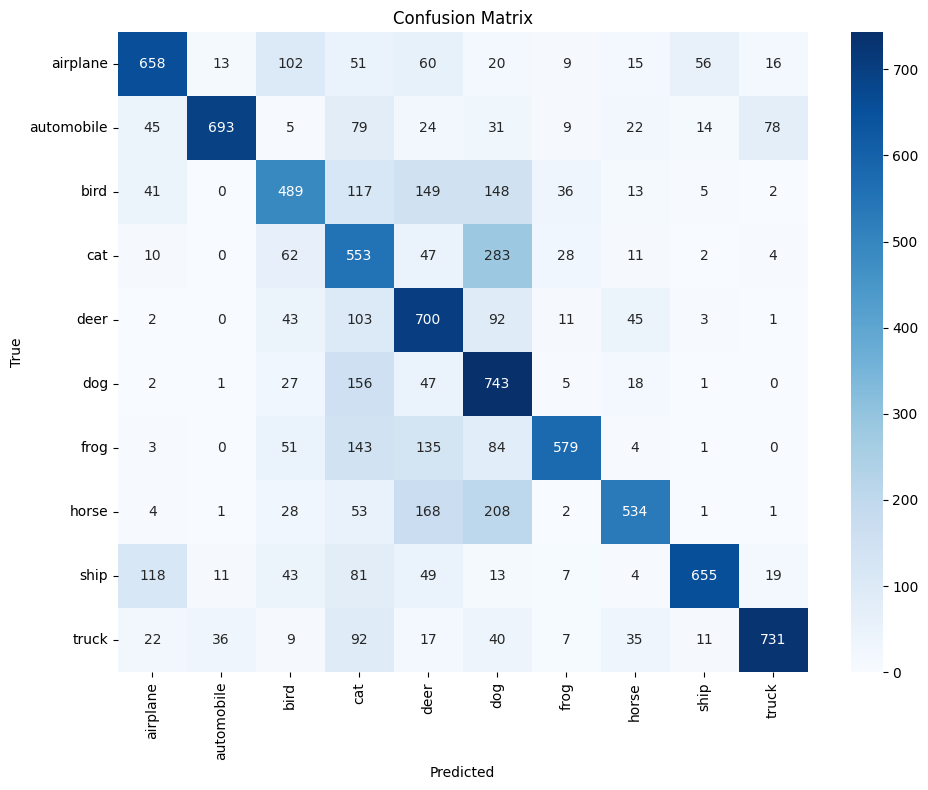

In [ ]:
model = WideResNet(depth=28, num_classes=10, widen_factor=2, dropRate=0.0)

model.load_state_dict(torch.load('uda_wideresnet_cifar10.pth'))
model.to(device)
evaluate(model, test_loader, device)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

# Your model here (e.g. ResNet, WideResNet, or SimpleCNN)
class YourModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # define architecture...
    def forward(self, x):
        ...

# Strong augmentation (for unlabeled)
class StrongAug:
    def __init__(self):
        self.aug = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.RandAugment(num_ops=2, magnitude=9),
            transforms.ToTensor(),
            transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261)),
        ])
    def __call__(self, img):
        return self.aug(img)

# Ramp‑up function (sigmoid or exponential)
def rampup(epoch, rampup_len):
    if epoch >= rampup_len:
        return 1.0
    else:
        phase = 1.0 - epoch / rampup_len
        return float(torch.exp(-5.0 * phase * phase))

def train_uda(model, labeled_loader, unlabeled_loader, test_loader,
              device, epochs=100, lambda_u_max=1.0, confidence_thresh=0.8,
              rampup_length=20):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.003)
    strong_aug = StrongAug()

    for epoch in range(epochs):
        model.train()
        lambda_u = lambda_u_max * rampup(epoch, rampup_length)

        unlabeled_iter = iter(unlabeled_loader)
        for (x_l, y_l) in labeled_loader:
            try:
                x_u, _ = next(unlabeled_iter)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                x_u, _ = next(unlabeled_iter)

            x_l, y_l = x_l.to(device), y_l.to(device)
            x_u = x_u.to(device)
            x_u_strong = torch.stack([strong_aug(img.cpu()) for img in x_u]).to(device)

            # supervised loss
            logits_l = model(x_l)
            loss_sup = F.cross_entropy(logits_l, y_l)

            # unsupervised consistency loss
            with torch.no_grad():
                logits_u = model(x_u)
                probs_u = F.softmax(logits_u / 1.0, dim=1)  # temperature = 1.0
                max_p, pseudo = torch.max(probs_u, dim=1)
                mask = (max_p >= confidence_thresh).float()

            logits_u_strong = model(x_u_strong)
            log_probs_strong = F.log_softmax(logits_u_strong, dim=1)
            loss_consistency_all = F.kl_div(log_probs_strong, probs_u, reduction='none').sum(dim=1)
            loss_consistency = (loss_consistency_all * mask).mean()

            loss = loss_sup + lambda_u * loss_consistency
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate on test set
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xt, yt in test_loader:
                xt, yt = xt.to(device), yt.to(device)
                yt_pred = model(xt).argmax(dim=1)
                correct += (yt_pred == yt).sum().item()
                total += yt.size(0)
        test_acc = correct / total
        print(f"Epoch {epoch}: test_acc = {test_acc:.4f}, λ_u = {lambda_u:.4f}")


In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import RandAugment
from tqdm import tqdm

# ========== WideResNet Implementation ==========
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = None
        if not self.equalInOut:
            self.convShortcut = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu(self.bn1(x))
            out = x
        else:
            out = self.relu(self.bn1(x))
        out = self.conv1(out)
        out = self.relu(self.bn2(out))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        shortcut = x if self.equalInOut else self.convShortcut(x)
        return out + shortcut

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super().__init__()
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes,
                                out_planes,
                                i == 0 and stride or 1,
                                dropRate))
        self.layer = nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth=28, widen_factor=2, num_classes=10, dropRate=0.0):
        super().__init__()
        assert ((depth - 4) % 6 == 0), "Depth must be 6n+4"
        n = (depth - 4) // 6
        k = widen_factor
        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = nn.Conv2d(3, nStages[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.block1 = NetworkBlock(n, nStages[0], nStages[1], BasicBlock, 1, dropRate)
        self.block2 = NetworkBlock(n, nStages[1], nStages[2], BasicBlock, 2, dropRate)
        self.block3 = NetworkBlock(n, nStages[2], nStages[3], BasicBlock, 2, dropRate)
        self.bn1 = nn.BatchNorm2d(nStages[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nStages[3], num_classes)
        self.nChannels = nStages[3]

        # weight init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

# ========== Augmentations ==========
class Cutout:
    def __init__(self, mask_size, p=1.0, mask_color=0):
        self.mask_size = mask_size
        self.p = p
        self.mask_color = mask_color

    def __call__(self, img):
        if random.random() > self.p:
            return img
        w, h = img.size
        mask_size_half = self.mask_size // 2
        cx = random.randint(mask_size_half, w - mask_size_half)
        cy = random.randint(mask_size_half, h - mask_size_half)
        x1 = cx - mask_size_half
        y1 = cy - mask_size_half
        x2 = cx + mask_size_half
        y2 = cy + mask_size_half
        img = img.copy()
        img.paste(self.mask_color, (x1, y1, x2, y2))
        return img

class StrongTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            transforms.RandAugment(num_ops=2, magnitude=9),
            Cutout(mask_size=16, p=1.0),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.247, 0.243, 0.261))
        ])

    def __call__(self, img):
        return self.transform(img)

# ========== Ramp-up function ==========
def rampup(epoch, rampup_length):
    if epoch >= rampup_length:
        return 1.0
    else:
        p = float(epoch) / float(rampup_length)
        return float(np.exp(-5.0 * (1.0 - p) * (1.0 - p)))

# ========== EMA update ==========
def update_ema(student, ema_model, alpha):
    for (name_s, param_s), (name_t, param_t) in zip(student.named_parameters(), ema_model.named_parameters()):
        # assume same names
        param_t.data.mul_(alpha).add_(param_s.data * (1.0 - alpha))

# ========== UDA training & saving ==========
def train_uda_cifar10(device, labeled_loader, unlabeled_loader, test_loader,
                      epochs=100, lambda_u_max=1.0, threshold=0.8, rampup_length=20, ema_decay=0.999):

    model = WideResNet(depth=28, widen_factor=2, num_classes=10).to(device)
    ema_model = WideResNet(depth=28, widen_factor=2, num_classes=10).to(device)
    ema_model.load_state_dict(model.state_dict())
    ema_model.eval()

    optimizer = optim.Adam(model.parameters(), lr=0.003)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss()
    strong_aug = StrongTransform()

    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        lambda_u = lambda_u_max * rampup(epoch, rampup_length)

        total_lab_loss, total_unsup_loss = 0.0, 0.0
        correct, total = 0, 0

        iter_unlab = iter(unlabeled_loader)

        for (x_l, y_l) in tqdm(labeled_loader, desc=f"Epoch {epoch+1}", leave=False):
            try:
                x_u, _ = next(iter_unlab)
            except StopIteration:
                iter_unlab = iter(unlabeled_loader)
                x_u, _ = next(iter_unlab)

            x_l, y_l = x_l.to(device), y_l.to(device)
            x_u = x_u.to(device)

            x_u_aug = torch.stack([strong_aug(img.cpu()) for img in x_u]).to(device)

            # supervised
            logits_l = model(x_l)
            loss_lab = criterion(logits_l, y_l)

            # pseudo-labels from weak prediction
            with torch.no_grad():
                logits_u = model(x_u)
                probs_u = F.softmax(logits_u, dim=1)
                max_p, pseudo = torch.max(probs_u, dim=1)
                mask = (max_p >= threshold).float()

            # consistency on strong
            logits_u_aug = model(x_u_aug)
            log_probs_aug = F.log_softmax(logits_u_aug, dim=1)
            unsup_loss_all = F.kl_div(log_probs_aug, probs_u, reduction='none').sum(dim=1)
            loss_unsup = (unsup_loss_all * mask).mean()

            loss = loss_lab + lambda_u * loss_unsup

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # EMA update
            update_ema(model, ema_model, ema_decay)

            total_lab_loss += loss_lab.item()
            total_unsup_loss += loss_unsup.item()
            preds = logits_l.argmax(dim=1)
            correct += (preds == y_l).sum().item()
            total += y_l.size(0)

        scheduler.step()
        train_acc = correct / total
        print(f"Epoch {epoch+1}/{epochs} — LR: {scheduler.get_last_lr()[0]:.6f}, Sup: {total_lab_loss/len(labeled_loader):.4f}, Unsup: {total_unsup_loss/len(labeled_loader):.4f}, Train Acc: {train_acc:.4f}, λu: {lambda_u:.3f}")

        # validation
        model.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for x_t, y_t in test_loader:
                x_t, y_t = x_t.to(device), y_t.to(device)
                logits = ema_model(x_t)  # use EMA model for inference
                preds = logits.argmax(dim=1)
                correct_test += (preds == y_t).sum().item()
                total_test += y_t.size(0)
        test_acc = correct_test / total_test
        print(f"→ Test (EMA) Acc: {test_acc:.4f}")

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(ema_model.state_dict(), "uda_cifar10_ema_best.pth")
            print("Saved new best EMA model")

    return model, ema_model

# ========== Setup CIFAR-10 DataLoaders ==========
def get_cifar10_loaders(num_labeled=4000, batch_size=64):
    normalize = transforms.Normalize((0.4914, 0.4822, 0.4465),
                                     (0.247, 0.243, 0.261))
    weak = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        normalize
    ])
    test_t = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    full = datasets.CIFAR10(root='./data', train=True, download=True, transform=weak)
    test = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_t)

    indices = np.arange(len(full))
    np.random.seed(42)
    np.random.shuffle(indices)
    labeled_idx = indices[:num_labeled]
    unlabeled_idx = indices[num_labeled:]

    labeled_set = Subset(full, labeled_idx)
    unlabeled_set = Subset(full, unlabeled_idx)

    labeled_loader = DataLoader(labeled_set, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
    unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
    test_loader = DataLoader(test, batch_size=100, shuffle=False, num_workers=2)

    return labeled_loader, unlabeled_loader, test_loader

# ========== Entry ==========
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    labeled_loader, unlabeled_loader, test_loader = get_cifar10_loaders(num_labeled=4000)
    model, ema_model = train_uda_cifar10(device, labeled_loader, unlabeled_loader, test_loader,
                                         epochs=100, lambda_u_max=1.0, threshold=0.8, rampup_length=20, ema_decay=0.999)
    print("Training done.")


100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]
                                                        

Epoch 1/100 — LR: 0.002999, Sup: 2.0368, Unsup: 0.0020, Train Acc: 0.2344, λu: 0.007


→ Test (EMA) Acc: 0.1000
Saved new best EMA model


Epoch 2/100 — LR: 0.002997, Sup: 1.8415, Unsup: 0.0000, Train Acc: 0.2939, λu: 0.011


→ Test (EMA) Acc: 0.1000


Epoch 3/100 — LR: 0.002993, Sup: 1.7914, Unsup: 0.0004, Train Acc: 0.3097, λu: 0.017


→ Test (EMA) Acc: 0.1001
Saved new best EMA model


Epoch 4/100 — LR: 0.002988, Sup: 1.7284, Unsup: 0.0037, Train Acc: 0.3432, λu: 0.027


→ Test (EMA) Acc: 0.1001


Epoch 5/100 — LR: 0.002982, Sup: 1.6723, Unsup: 0.0160, Train Acc: 0.3753, λu: 0.041


→ Test (EMA) Acc: 0.1190
Saved new best EMA model


Epoch 6/100 — LR: 0.002973, Sup: 1.6168, Unsup: 0.0246, Train Acc: 0.3891, λu: 0.060


→ Test (EMA) Acc: 0.1111


Epoch 7/100 — LR: 0.002964, Sup: 1.5682, Unsup: 0.0454, Train Acc: 0.4095, λu: 0.086


→ Test (EMA) Acc: 0.1035


Epoch 8/100 — LR: 0.002953, Sup: 1.4868, Unsup: 0.0832, Train Acc: 0.4453, λu: 0.121


→ Test (EMA) Acc: 0.1002


Epoch 9/100 — LR: 0.002940, Sup: 1.4358, Unsup: 0.1232, Train Acc: 0.4662, λu: 0.165


→ Test (EMA) Acc: 0.0999


Epoch 10/100 — LR: 0.002927, Sup: 1.3581, Unsup: 0.1871, Train Acc: 0.5025, λu: 0.220


→ Test (EMA) Acc: 0.0999


Epoch 11/100 — LR: 0.002911, Sup: 1.3105, Unsup: 0.2234, Train Acc: 0.5204, λu: 0.287


→ Test (EMA) Acc: 0.1001


Epoch 12/100 — LR: 0.002895, Sup: 1.2587, Unsup: 0.2501, Train Acc: 0.5426, λu: 0.363


→ Test (EMA) Acc: 0.0999


Epoch 13/100 — LR: 0.002877, Sup: 1.1981, Unsup: 0.2768, Train Acc: 0.5643, λu: 0.449


→ Test (EMA) Acc: 0.0999


Epoch 14/100 — LR: 0.002857, Sup: 1.1914, Unsup: 0.3136, Train Acc: 0.5693, λu: 0.542


→ Test (EMA) Acc: 0.1000


Epoch 15/100 — LR: 0.002837, Sup: 1.1345, Unsup: 0.3057, Train Acc: 0.5857, λu: 0.638


→ Test (EMA) Acc: 0.1000


Epoch 16/100 — LR: 0.002814, Sup: 1.0999, Unsup: 0.3166, Train Acc: 0.5983, λu: 0.732


→ Test (EMA) Acc: 0.1000


Epoch 17/100 — LR: 0.002791, Sup: 1.0448, Unsup: 0.3514, Train Acc: 0.6253, λu: 0.819


→ Test (EMA) Acc: 0.1000


Epoch 18/100 — LR: 0.002766, Sup: 1.0019, Unsup: 0.3907, Train Acc: 0.6346, λu: 0.894


→ Test (EMA) Acc: 0.1000


Epoch 19/100 — LR: 0.002741, Sup: 0.9705, Unsup: 0.4005, Train Acc: 0.6507, λu: 0.951


→ Test (EMA) Acc: 0.1000


Epoch 20/100 — LR: 0.002714, Sup: 0.9516, Unsup: 0.4377, Train Acc: 0.6573, λu: 0.988


→ Test (EMA) Acc: 0.1000


Epoch 21/100 — LR: 0.002685, Sup: 0.9310, Unsup: 0.4439, Train Acc: 0.6643, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 22/100 — LR: 0.002656, Sup: 0.8848, Unsup: 0.4867, Train Acc: 0.6860, λu: 1.000


→ Test (EMA) Acc: 0.0999


Epoch 23/100 — LR: 0.002625, Sup: 0.8972, Unsup: 0.4805, Train Acc: 0.6711, λu: 1.000


→ Test (EMA) Acc: 0.0999


Epoch 24/100 — LR: 0.002593, Sup: 0.8305, Unsup: 0.5253, Train Acc: 0.7034, λu: 1.000


→ Test (EMA) Acc: 0.1069


Epoch 25/100 — LR: 0.002561, Sup: 0.8110, Unsup: 0.5563, Train Acc: 0.7014, λu: 1.000


→ Test (EMA) Acc: 0.0996


Epoch 26/100 — LR: 0.002527, Sup: 0.7569, Unsup: 0.6103, Train Acc: 0.7261, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 27/100 — LR: 0.002492, Sup: 0.7570, Unsup: 0.6057, Train Acc: 0.7278, λu: 1.000


→ Test (EMA) Acc: 0.1001


Epoch 28/100 — LR: 0.002456, Sup: 0.7318, Unsup: 0.6588, Train Acc: 0.7371, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 29/100 — LR: 0.002419, Sup: 0.7134, Unsup: 0.6131, Train Acc: 0.7392, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 30/100 — LR: 0.002382, Sup: 0.6550, Unsup: 0.6982, Train Acc: 0.7649, λu: 1.000


→ Test (EMA) Acc: 0.1002


Epoch 31/100 — LR: 0.002343, Sup: 0.6472, Unsup: 0.7013, Train Acc: 0.7709, λu: 1.000


→ Test (EMA) Acc: 0.0951


Epoch 32/100 — LR: 0.002304, Sup: 0.6010, Unsup: 0.7444, Train Acc: 0.7848, λu: 1.000


→ Test (EMA) Acc: 0.0773


Epoch 33/100 — LR: 0.002264, Sup: 0.5884, Unsup: 0.7641, Train Acc: 0.7893, λu: 1.000


→ Test (EMA) Acc: 0.0744


Epoch 34/100 — LR: 0.002223, Sup: 0.5533, Unsup: 0.8084, Train Acc: 0.8057, λu: 1.000


→ Test (EMA) Acc: 0.0976


Epoch 35/100 — LR: 0.002181, Sup: 0.5249, Unsup: 0.8570, Train Acc: 0.8163, λu: 1.000


→ Test (EMA) Acc: 0.0996


Epoch 36/100 — LR: 0.002139, Sup: 0.5036, Unsup: 0.8319, Train Acc: 0.8145, λu: 1.000


→ Test (EMA) Acc: 0.0999


Epoch 37/100 — LR: 0.002096, Sup: 0.4901, Unsup: 0.8569, Train Acc: 0.8238, λu: 1.000


→ Test (EMA) Acc: 0.0999


Epoch 38/100 — LR: 0.002052, Sup: 0.4820, Unsup: 0.8676, Train Acc: 0.8296, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 39/100 — LR: 0.002008, Sup: 0.4515, Unsup: 0.8739, Train Acc: 0.8385, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 40/100 — LR: 0.001964, Sup: 0.4264, Unsup: 0.9022, Train Acc: 0.8495, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 41/100 — LR: 0.001918, Sup: 0.4083, Unsup: 0.9485, Train Acc: 0.8564, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 42/100 — LR: 0.001873, Sup: 0.3618, Unsup: 0.9182, Train Acc: 0.8742, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 43/100 — LR: 0.001827, Sup: 0.3802, Unsup: 0.9787, Train Acc: 0.8647, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 44/100 — LR: 0.001781, Sup: 0.3424, Unsup: 0.9732, Train Acc: 0.8818, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 45/100 — LR: 0.001735, Sup: 0.3189, Unsup: 0.9994, Train Acc: 0.8848, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 46/100 — LR: 0.001688, Sup: 0.2998, Unsup: 1.0176, Train Acc: 0.8952, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 47/100 — LR: 0.001641, Sup: 0.2939, Unsup: 0.9997, Train Acc: 0.8952, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 48/100 — LR: 0.001594, Sup: 0.2654, Unsup: 1.0336, Train Acc: 0.9055, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 49/100 — LR: 0.001547, Sup: 0.2454, Unsup: 1.0642, Train Acc: 0.9143, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 50/100 — LR: 0.001500, Sup: 0.2264, Unsup: 1.0585, Train Acc: 0.9216, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 51/100 — LR: 0.001453, Sup: 0.2250, Unsup: 1.0537, Train Acc: 0.9244, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 52/100 — LR: 0.001406, Sup: 0.2070, Unsup: 1.0814, Train Acc: 0.9282, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 53/100 — LR: 0.001359, Sup: 0.1977, Unsup: 1.0972, Train Acc: 0.9304, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 54/100 — LR: 0.001312, Sup: 0.1786, Unsup: 1.1169, Train Acc: 0.9383, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 55/100 — LR: 0.001265, Sup: 0.1769, Unsup: 1.1088, Train Acc: 0.9410, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 56/100 — LR: 0.001219, Sup: 0.1480, Unsup: 1.1462, Train Acc: 0.9504, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 57/100 — LR: 0.001173, Sup: 0.1294, Unsup: 1.1322, Train Acc: 0.9539, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 58/100 — LR: 0.001127, Sup: 0.1400, Unsup: 1.1281, Train Acc: 0.9506, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 59/100 — LR: 0.001082, Sup: 0.1354, Unsup: 1.1369, Train Acc: 0.9514, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 60/100 — LR: 0.001036, Sup: 0.1126, Unsup: 1.1599, Train Acc: 0.9627, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 61/100 — LR: 0.000992, Sup: 0.1233, Unsup: 1.1679, Train Acc: 0.9597, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 62/100 — LR: 0.000948, Sup: 0.0997, Unsup: 1.1513, Train Acc: 0.9685, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 63/100 — LR: 0.000904, Sup: 0.0877, Unsup: 1.1721, Train Acc: 0.9723, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 64/100 — LR: 0.000861, Sup: 0.0853, Unsup: 1.1469, Train Acc: 0.9718, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 65/100 — LR: 0.000819, Sup: 0.0702, Unsup: 1.1850, Train Acc: 0.9811, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 66/100 — LR: 0.000777, Sup: 0.0767, Unsup: 1.1768, Train Acc: 0.9773, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 67/100 — LR: 0.000736, Sup: 0.0734, Unsup: 1.2052, Train Acc: 0.9766, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 68/100 — LR: 0.000696, Sup: 0.0736, Unsup: 1.2079, Train Acc: 0.9768, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 69/100 — LR: 0.000657, Sup: 0.0733, Unsup: 1.1995, Train Acc: 0.9781, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 70/100 — LR: 0.000618, Sup: 0.0636, Unsup: 1.1902, Train Acc: 0.9803, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 71/100 — LR: 0.000581, Sup: 0.0492, Unsup: 1.1711, Train Acc: 0.9851, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 72/100 — LR: 0.000544, Sup: 0.0503, Unsup: 1.1980, Train Acc: 0.9854, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 73/100 — LR: 0.000508, Sup: 0.0623, Unsup: 1.2034, Train Acc: 0.9793, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 74/100 — LR: 0.000473, Sup: 0.0552, Unsup: 1.1818, Train Acc: 0.9846, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 75/100 — LR: 0.000439, Sup: 0.0481, Unsup: 1.2110, Train Acc: 0.9854, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 76/100 — LR: 0.000407, Sup: 0.0494, Unsup: 1.1842, Train Acc: 0.9874, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 77/100 — LR: 0.000375, Sup: 0.0448, Unsup: 1.2192, Train Acc: 0.9884, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 78/100 — LR: 0.000344, Sup: 0.0414, Unsup: 1.1924, Train Acc: 0.9894, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 79/100 — LR: 0.000315, Sup: 0.0343, Unsup: 1.2148, Train Acc: 0.9912, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 80/100 — LR: 0.000286, Sup: 0.0337, Unsup: 1.2157, Train Acc: 0.9912, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 81/100 — LR: 0.000259, Sup: 0.0245, Unsup: 1.1865, Train Acc: 0.9952, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 82/100 — LR: 0.000234, Sup: 0.0254, Unsup: 1.2018, Train Acc: 0.9947, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 83/100 — LR: 0.000209, Sup: 0.0262, Unsup: 1.2025, Train Acc: 0.9945, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 84/100 — LR: 0.000186, Sup: 0.0277, Unsup: 1.2366, Train Acc: 0.9937, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 85/100 — LR: 0.000163, Sup: 0.0286, Unsup: 1.2008, Train Acc: 0.9947, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 86/100 — LR: 0.000143, Sup: 0.0269, Unsup: 1.2104, Train Acc: 0.9934, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 87/100 — LR: 0.000123, Sup: 0.0253, Unsup: 1.2010, Train Acc: 0.9934, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 88/100 — LR: 0.000105, Sup: 0.0233, Unsup: 1.2288, Train Acc: 0.9957, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 89/100 — LR: 0.000089, Sup: 0.0206, Unsup: 1.2036, Train Acc: 0.9957, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 90/100 — LR: 0.000073, Sup: 0.0277, Unsup: 1.2137, Train Acc: 0.9932, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 91/100 — LR: 0.000060, Sup: 0.0265, Unsup: 1.2269, Train Acc: 0.9947, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 92/100 — LR: 0.000047, Sup: 0.0238, Unsup: 1.2103, Train Acc: 0.9965, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 93/100 — LR: 0.000036, Sup: 0.0189, Unsup: 1.2263, Train Acc: 0.9970, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 94/100 — LR: 0.000027, Sup: 0.0204, Unsup: 1.2187, Train Acc: 0.9965, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 95/100 — LR: 0.000018, Sup: 0.0243, Unsup: 1.2322, Train Acc: 0.9957, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 96/100 — LR: 0.000012, Sup: 0.0252, Unsup: 1.2182, Train Acc: 0.9945, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 97/100 — LR: 0.000007, Sup: 0.0229, Unsup: 1.2028, Train Acc: 0.9952, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 98/100 — LR: 0.000003, Sup: 0.0207, Unsup: 1.1877, Train Acc: 0.9950, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 99/100 — LR: 0.000001, Sup: 0.0166, Unsup: 1.1903, Train Acc: 0.9977, λu: 1.000


→ Test (EMA) Acc: 0.1000


Epoch 100/100 — LR: 0.000000, Sup: 0.0192, Unsup: 1.1945, Train Acc: 0.9962, λu: 1.000


→ Test (EMA) Acc: 0.1000
Training done.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

def evaluate(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    # Flatten predictions and labels
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()

    # Compute accuracy
    accuracy = np.mean(y_pred == y_true)
    print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ],
                yticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


✅ Test Accuracy: 61.94%

📊 Classification Report:
              precision    recall  f1-score   support

    airplane       0.59      0.79      0.67      1000
  automobile       0.92      0.72      0.80      1000
        bird       0.68      0.40      0.50      1000
         cat       0.31      0.82      0.45      1000
        deer       0.49      0.74      0.59      1000
         dog       0.69      0.35      0.47      1000
        frog       0.88      0.50      0.64      1000
       horse       0.86      0.54      0.67      1000
        ship       0.89      0.69      0.78      1000
       truck       0.93      0.64      0.76      1000

    accuracy                           0.62     10000
   macro avg       0.73      0.62      0.63     10000
weighted avg       0.73      0.62      0.63     10000



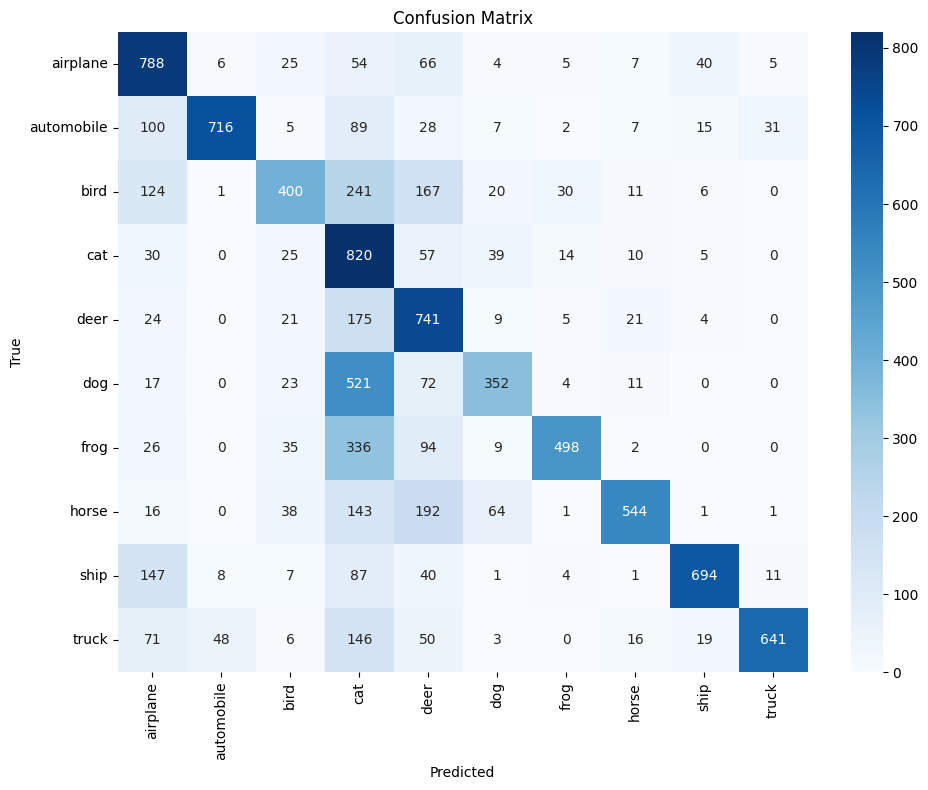

In [ ]:
# model = WideResNet(depth=28, num_classes=10, widen_factor=2, dropRate=0.0)

# model.load_state_dict(torch.load('uda_wideresnet_cifar10.pth'))
# model.to(device)
evaluate(model, test_loader, device)